In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the required libraries.
import os
import cv2

import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy import *

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 2
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ShopDataSet.zip' -d '/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip'

Archive:  /content/drive/MyDrive/Colab Notebooks/ShopDataSet.zip
replace /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0_1.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_1.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_1_1.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_10.mp4  
  inflating: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_10_1.mp4  
  inflating: /content/drive/MyDrive/Col

In [5]:
all_classes_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet')
all_classes_names

['shop lifters', 'non shop lifters']

In [6]:
print('normal', len(os.listdir('/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters')))
print('shoplifting', len(os.listdir('/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/shop lifters')))

normal 531
shoplifting 324


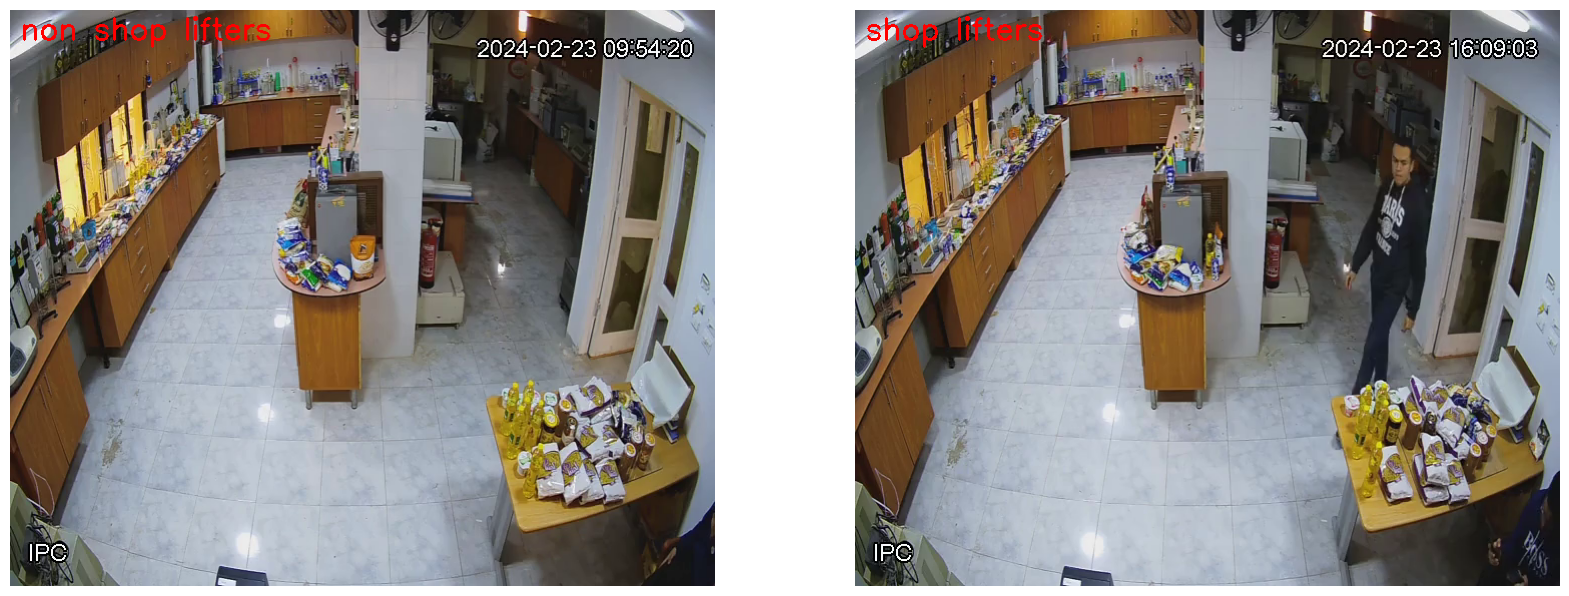

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Define the base directory where the videos are located
base_dir = '/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet'

# Get the names of all classes/categories in the dataset
all_classes_names = ['non shop lifters', 'shop lifters']  # Define your classes explicitly

# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Generate a list of 2 random indices based on the number of classes
random_range = random.sample(range(len(all_classes_names)), 2)

# Iterating through all the generated random indices.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_name = all_classes_names[random_index]

    # Construct the path for the selected class directory.
    class_path = os.path.join(base_dir, selected_class_name)

    # Retrieve the list of all video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(class_path)

    # Randomly select a video file from the list retrieved from the selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(os.path.join(class_path, selected_video_file_name))

    # Read the first frame of the video file.
    success, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Check if the frame was read successfully
    if success:
        # Convert the frame from BGR into RGB format.
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Write the class name on the video frame.
        cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        # Display the frame in the specified subplot.
        plt.subplot(1, 2, counter)  # Adjust this based on how many images you are displaying
        plt.imshow(rgb_frame)
        plt.axis('off')  # Hide axes for better visualization
    else:
        print(f"Failed to read frame from video: {selected_video_file_name}")

# Show the plot
plt.show()


In [8]:
IMAGE_HEIGHT , IMAGE_WIDTH = 80,80
SEQUENCE_LENGTH = 20
CLASSES_LIST = ['non shop lifters', 'shop lifters']

In [9]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames_list

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video {video_path}: {video_frames_count}")

    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            print(f"Failed to read frame at {frame_counter * skip_frames_window} from {video_path}")
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


In [10]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(base_dir, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(base_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)

            print(f"Processed video: {video_file_path}, Frames extracted: {len(frames)}")

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            else:
                print(f"Skipping video {file_name}: not enough frames ({len(frames)})")

    features = np.asarray(features)
    labels = np.array(labels)

    print(f"Total extracted features shape: {features.shape}")
    return features, labels, video_files_paths


In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10357131918321459802
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3394201478261364456
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [12]:
features, labels, video_files_paths = create_dataset()


Extracting Data of Class: non shop lifters
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/videossssstttsss_48.mp4: 175
Processed video: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/videossssstttsss_48.mp4, Frames extracted: 20
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/videossssstttsss_49.mp4: 225
Processed video: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/videossssstttsss_49.mp4, Frames extracted: 20
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/videossssstttsss_50.mp4: 325
Processed video: /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/videossssstttsss_50.mp4, Frames extracted: 20
Total frames in video /content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/n

In [13]:
features.shape

(855, 20, 80, 80, 3)

In [14]:
one_hot_encoded_labels = to_categorical(labels)

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.3, shuffle = True,
                                                                            random_state = seed_constant)

In [16]:
!pip install gdown


In [17]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [18]:

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [19]:
def create_LRCN_model():

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [20]:
LRCN_model = create_LRCN_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 80, 80, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 20, 20, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 20, 20, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 20, 20, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 5, 5, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 5, 5, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 5, 5, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 2, 2, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,994 (285.13 KB)

 Trainable params: 72,994 (285.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 16 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.6149 - loss: 0.6768 - val_accuracy: 0.5750 - val_loss: 0.6865
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6226 - loss: 0.6658 - val_accuracy: 0.5750 - val_loss: 0.6846
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6226 - loss: 0.6668 - val_accuracy: 0.5750 - val_loss: 0.6839
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.6226 - loss: 0.6666 - val_accuracy: 0.5750 - val_loss: 0.6835
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.6226 - loss: 0.6638 - val_accuracy: 0.5750 - val_loss: 0.6833
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6226 - loss: 0.6626 - val_accuracy: 0.5750 - val_loss: 0.6843
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.6226 - loss: 0.6641 - val_accuracy: 0.5750 - val_loss: 0.6823
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.6226 - loss: 0.6649 - val_accuracy: 0

In [22]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9916 - loss: 0.0283


In [23]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [24]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

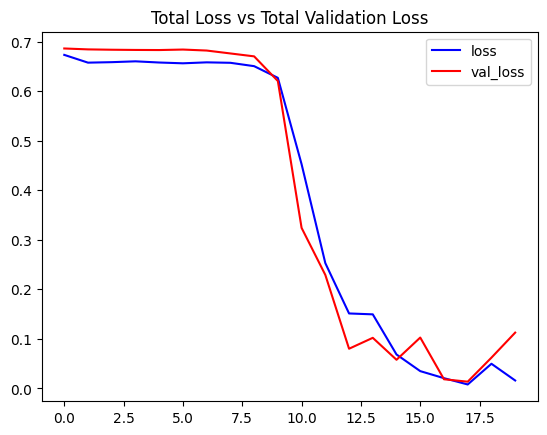

In [25]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


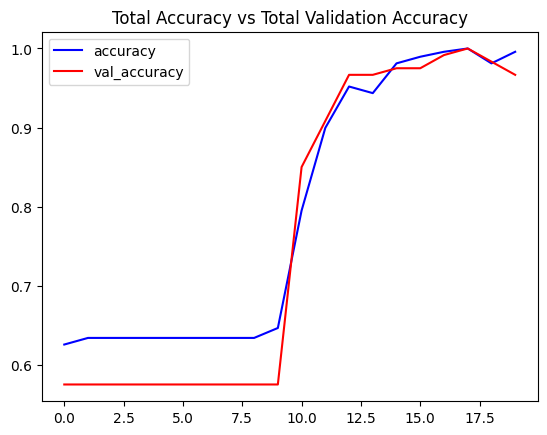

In [26]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


In [27]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()

In [28]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [29]:
from IPython.display import Video
input_video_file_path = "/content/drive/MyDrive/Colab Notebooks/ShopDataSet.unzip/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4"
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
show_video(input_video_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Action Predicted: non shop lifters
Confidence: 0.968525230884552
